# Habitat-sim Basics for Navigation

The Habitat platform relies on a number of key abstractions that model the domain of embodied agents and tasks that can be carried out in three-dimensional indoor simulation environments.

- **Agent**: a virtually embodied agent (e.g., a robot) with a suite of Sensors. Can observe the environment and is capable of taking actions that change agent or environment state.
- **Sensor**: associated with a specific Agent, capable of returning observation data from the environment at a specified frequency.
- **Scene**: a 3D environment containing a scene mesh, objects, Agents, and Sensors.
- **SceneGraph**: a hierarchical representation of a Scene that organizes the environment into regions and objects. Can be programmatically manipulated. All Scene components are present on the SceneGraph.
- **Simulator**: an instance of a simulator backend. Given actions for a set of configured Agents and SceneGraphs, can update the state of the Agents and SceneGraphs, and provide observations for all active Sensors possessed by the Agents.

This tutorial covers the basics of using Habitat-sim for navigation tasks, including:
- configuration of a Simulator, Sensors, and Agents.
- taking actions and retrieving observations
- pathfinding and navigation on the NavMesh

In [1]:
import math
import random

import imageio
import magnum as mn
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

import os
import habitat_sim

from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut


# Set up ffmpeg path for local system
# (Ensure ffmpeg is installed locally, e.g., via `sudo apt install ffmpeg` on Ubuntu)
#os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

# Define path to current directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# Data path setup
data_path = os.path.join(dir_path, "data")

# Output path setup
output_path = os.path.join(dir_path, "outputs")


In [2]:
# @title Define Observation Display Utility Function { display-mode: "form" }

# @markdown A convenient function that displays sensor observations with matplotlib.

# @markdown (double click to see the code)


# Change to do something like this maybe: https://stackoverflow.com/a/41432704
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


# "Hello, World!"

Habitat simulator for navigation consists of **3** important concepts:
- configurable embodied agents
- multiple sensors
- Scene: generic 3D dataset handling (e.g., Matterport, Gibson, and Replica datasets).

In the 1st example, we demonstrate how to setup 1 agent with only 1 sensor (RGB visual sensor), place it in a scene, instruct it to navigate and collect the observations.

### Basic settings

To begin with, we specify a scene we are going to load, designate a default agent, and describe a couple of basic sensor parameters, such as the type, position, resolution of the obeservation (width and height).

In [3]:
# This is the scene we are going to load.
# we support a variety of mesh formats, such as .glb, .gltf, .obj, .ply
test_scene = "./data/scene_datasets/mp3d/17DRP5sb8fy/17DRP5sb8fy.glb"

sim_settings = {
    "scene": test_scene,  # Scene path
    "default_agent": 0,  # Index of the default agent
    "sensor_height": 1.5,  # Height of sensors in meters, relative to the agent
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
}

### Configurations for the simulator

To run the simulator, we need to create a configuration that are understandable by our simulator.\
Such a configuration consists of **2** parts:
- **One for the simulator backend.** It specifies parameters that are required to start and run the simulator. For example, the scene to be loaded, whether to load the semantic mesh, to enable physics or not. (Details: [code](https://github.com/facebookresearch/habitat-sim/blob/5820e1adc3ab238d2f564241d4705da5755542c9/src/esp/sim/Simulator.h#L44))
- **One for the agent.** It describes parameters to initialize an agent, such as height, mass, as well as the configs for the attached sensors. User can also define the amount of displacement e.g., in a forward action and the turn angle.
(Details: [code](https://github.com/facebookresearch/habitat-sim/blob/5820e1adc3ab238d2f564241d4705da5755542c9/src/esp/agent/Agent.h#L52))

In [4]:
# This function generates a config for the simulator.
# It contains two parts:
# one for the simulator backend
# one for the agent, where you can attach a bunch of sensors
def make_simple_cfg(settings):
    # simulator backend
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.scene_id = settings["scene"]

    # agent
    agent_cfg = habitat_sim.agent.AgentConfiguration()

    # In the 1st example, we attach only one sensor,
    # a RGB visual sensor, to the agent
    rgb_sensor_spec = habitat_sim.CameraSensorSpec()
    rgb_sensor_spec.uuid = "color_sensor"
    rgb_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    rgb_sensor_spec.resolution = [settings["height"], settings["width"]]
    rgb_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]

    agent_cfg.sensor_specifications = [rgb_sensor_spec]

    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


cfg = make_simple_cfg(sim_settings)

### Create a simulator instance

In [5]:
sim = habitat_sim.Simulator(cfg)

Renderer: NVIDIA GeForce GTX 1060 6GB/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.183.01
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[10:00:50:303665]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


### Generate top-down map

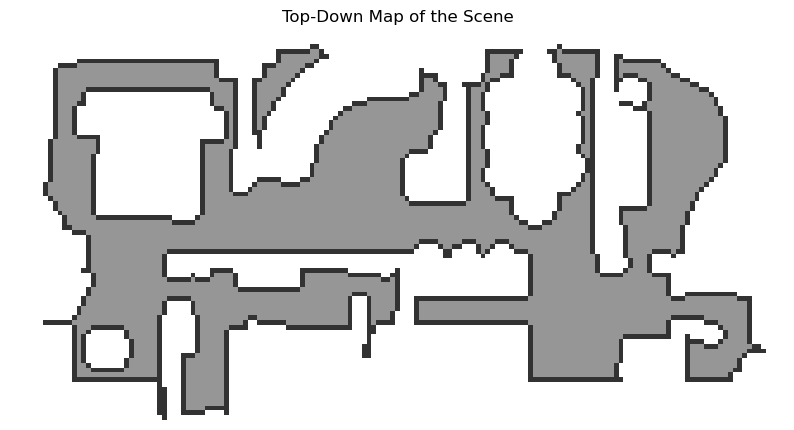

In [8]:
def get_topdown_map(sim):
    # Get the map with the default resolution
    topdown_map = maps.get_topdown_map(sim.pathfinder, height=0, meters_per_pixel=0.1)
    
    # Convert to a displayable format
    map_image = maps.colorize_topdown_map(topdown_map)
    
    return map_image

# Generate the top-down map
topdown_map = get_topdown_map(sim)

# Display the top-down map
plt.figure(figsize=(10, 10))
plt.imshow(topdown_map)
plt.axis("off")
plt.title("Top-Down Map of the Scene")
plt.show()

### Initialize the agent in a random position (unoccupied)

In [9]:
# Initialize the agent
agent = sim.initialize_agent(sim_settings["default_agent"])

# Function to find a random navigable position
def get_random_navigable_position(sim):
    return sim.pathfinder.get_random_navigable_point()

# Set the agent's initial state
agent_state = habitat_sim.AgentState()
agent_state.position = get_random_navigable_position(sim)  # Get a random navigable position
agent.set_state(agent_state)

# Print agent's initial position
print(f"Agent spawned at position: {agent_state.position}")


Agent spawned at position: Vector(0.393018, 0.072447, 0.145209)


### Plot the agent position on the unoccupied map

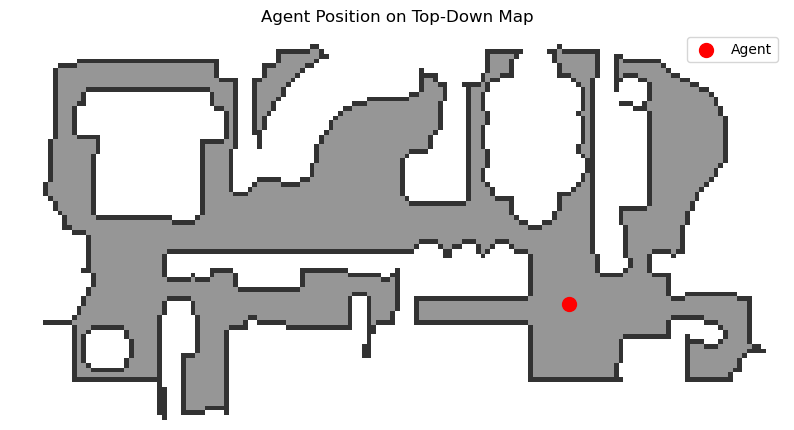

In [ ]:
# Function to plot agent's position on the top-down map
def plot_agent_on_map(sim, agent):
    # Generate top-down map
    topdown_map = maps.get_topdown_map(sim.pathfinder, height=0, meters_per_pixel=0.1)
    map_image = maps.colorize_topdown_map(topdown_map)

    # Get agent position
    agent_position = agent.get_state().position
    map_agent_pos = maps.to_grid(
        agent_position[0], agent_position[2],  # Convert 3D position to 2D
        topdown_map.shape[:2], 
        pathfinder=sim.pathfinder
    )

    # Plot map and agent position
    plt.figure(figsize=(10, 10))
    plt.imshow(map_image)
    plt.scatter(map_agent_pos[1], map_agent_pos[0], c="red", marker="o", s=100, label="Agent")  # Mark agent
    plt.axis("off")
    plt.legend()
    plt.title("Agent Position on Top-Down Map")
    plt.show()

# Call the function to display the agent on the map
plot_agent_on_map(sim, agent)

### Get some observations of the scene

Discrete action space:  ['move_forward', 'turn_left', 'turn_right']
action:  move_forward


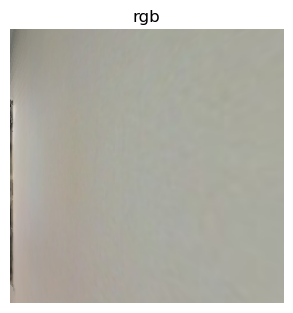

action:  turn_right


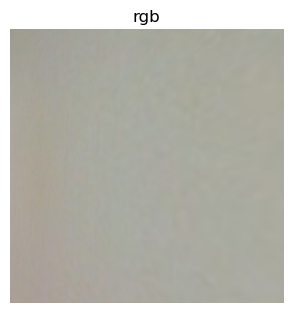

action:  turn_left


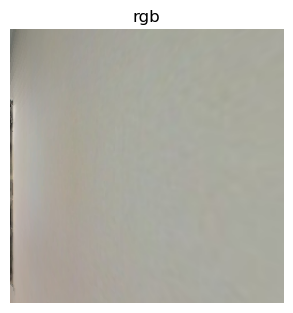

action:  move_forward


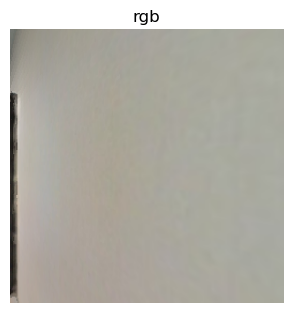

action:  move_forward


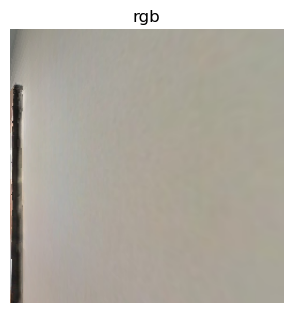

In [19]:
# obtain the default, discrete actions that an agent can perform
# default action space contains 3 actions: move_forward, turn_left, and turn_right
action_names = list(cfg.agents[sim_settings["default_agent"]].action_space.keys())
print("Discrete action space: ", action_names)

def navigateAndSee(action=""):
    if action in action_names:
        observations = sim.step(action)
        print("action: ", action)
        if display:
            display_sample(observations["color_sensor"])

iter = 0
while iter < 5:
    action = random.choice(action_names)
    navigateAndSee(action)
    iter += 1

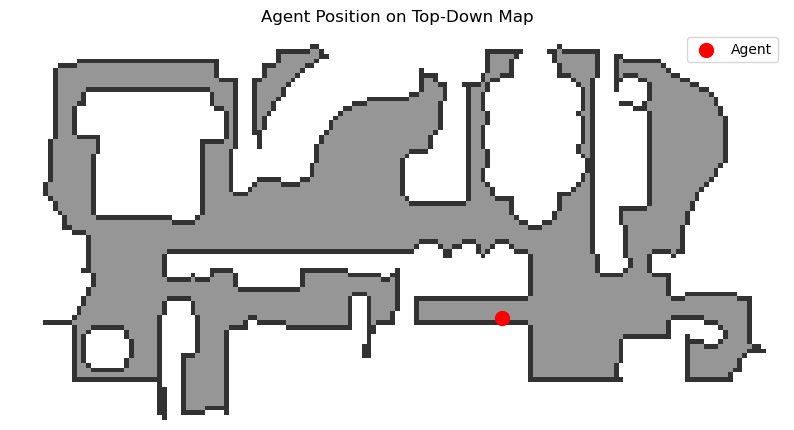

In [20]:
# Call the function to display the agent on the map
plot_agent_on_map(sim, agent)

### Make a little video

In [22]:
# Define a function to create an in-memory video
def create_video_in_memory(sim, num_frames=500, fps=10):
    action_names = list(cfg.agents[0].action_space.keys())  # Get possible actions
    video_frames = []  # List to store frames in memory

    for _ in range(num_frames):
        action = random.choice(action_names)  # Choose a random action
        observations = sim.step(action)  # Step simulation

        # Convert RGB observation to an image
        frame = observations["color_sensor"]
        video_frames.append(frame)  # Store in list

    # Save video in-memory without writing temporary files
    video_path = os.path.join(output_path, "output.mp4")
    with imageio.get_writer(video_path, fps=fps, quality=5, format="mp4") as writer:
        for frame in video_frames:
            writer.append_data(frame)

    print(f"Video saved to: {video_path}")

# Run the function to create a video
create_video_in_memory(sim, num_frames=500, fps=10)

Video saved to: /home/joaocbranco/projects/habitat-meta/experiments/outputs/output.mp4
